# Experimental: Extract BERT embeddings for each noun in a poem

To see if we can find any correlation of subject continuity and word embeddings of all of a poem's nouns, I put together some code together to lay the ground work for that.

First, I implemented a function that takes a poem and outputs the BERT embedding for each token.
Second, there is another function that extracts all nouns (and their word index) from a poem.

Note that BERT operates on subword basis: While most of the common English words are a token as themselves, less common words (e.g. "embeddings") are split up into multiple tokens. In the most extreme case, each character of a word is a token in itself.

Hence, BERT might output multiple token embeddings for a given word. To get all the token embeddings of a given word, the function `get_token_embeddings` outputs besides the actual embeddings also a mapping, so that we can reconstruct which embedding belongs to which token, and which tokens belong to which word in the input.

Similarly, the function `get_nouns_in_poem` does not only output the nouns themselves, but also their indexes in the original poem, so that we can simply fetch all token embeddings that belong to some noun.

Here is a useful tutorial about how to get the word embeddings from BERT (I copied a lot of stuff from there):
https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/

In [ ]:
!pip install transformers
import torch
import numpy as np
import random
from transformers import BertTokenizerFast, BertModel
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('treebank')

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True)

In [3]:
def get_token_embeddings(tokenizer, model, poem):
    """Retrieve the BERT embedding of each token in a poem

    :param tokenizer: BERT Fast tokenizer
    :param model: BERT pre-trained model
    :param poem: poem as a single string
    :return: (mapping of word index to token, embeddings for each token)
    """
    # Tokenize the poem
    marked_poem = "[CLS] " + poem + " [SEP]"
    bert_tokenized_poem = tokenizer.tokenize(marked_poem)

    # Get the word to token ID mapping
    encoded_poem = tokenizer(poem)
    word_ids = encoded_poem.word_ids()
    word_to_token = list(zip(word_ids, bert_tokenized_poem))[1:-1]

    num_words = word_to_token[-1][0] + 1
    word_token_mapping = [[] for _ in range(num_words)]

    for token_index, (word_id, token) in enumerate(word_to_token):
        word_token_mapping[word_id].append(token_index)

    # Get all hidden states
    indexed_tokens = tokenizer.convert_tokens_to_ids(bert_tokenized_poem)
    segment_ids = [1] * len(bert_tokenized_poem)

    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segment_ids])

    model.eval()
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
    hidden_states = torch.stack(outputs[2], dim=0).squeeze(dim=1).permute(1,0,2)

    # Concat last four layers as final embedding
    embeddings = []
    for token in hidden_states[1:-1]:
        last_four_layers = torch.cat([token[-i] for i in range(1, 5)], dim=0)
        embeddings.append(last_four_layers)
    
    return word_token_mapping, embeddings

## Example 1: Each word consists only of one token

In [4]:
poem_1 = """
although chocolate cookies are sweet
used for jelly, a warm drink or a treat
with some nut, and some spice
and some cream. if it’s nice
it’s the flavor that makes you a treat
"""

In [5]:
word_token_mapping_1, embeddings_1 = get_token_embeddings(tokenizer, model, poem_1)

print(f"Number of tokens: {len(embeddings_1)}")
print(f"Shape of each embedding: {embeddings_1[0].shape}\n")

word_token_mapping_1

Number of tokens: 41
Shape of each embedding: torch.Size([3072])



[[0],
 [1],
 [2],
 [3],
 [4],
 [5],
 [6],
 [7],
 [8],
 [9],
 [10],
 [11],
 [12],
 [13],
 [14],
 [15],
 [16],
 [17],
 [18],
 [19],
 [20],
 [21],
 [22],
 [23],
 [24],
 [25],
 [26],
 [27],
 [28],
 [29],
 [30],
 [31],
 [32],
 [33],
 [34],
 [35],
 [36],
 [37],
 [38],
 [39],
 [40]]

# Example 2: Words that consist of multiple tokens

In [6]:
poem_2 = """
I haven’t switched on my TV for years
we have people like me, and my fears
i talk to the news
i am paying my dues
rarely and loudly despise all my peers
"""

In [7]:
word_token_mapping_2, embeddings_2 = get_token_embeddings(tokenizer, model, poem_2)

print(f"Number of tokens: {len(embeddings_2)}")
print(f"Shape of each embedding: {embeddings_2[0].shape}\n")

word_token_mapping_2

Number of tokens: 39
Shape of each embedding: torch.Size([3072])



[[0],
 [1],
 [2],
 [3],
 [4],
 [5],
 [6],
 [7],
 [8],
 [9],
 [10],
 [11],
 [12],
 [13],
 [14],
 [15],
 [16],
 [17],
 [18],
 [19],
 [20],
 [21],
 [22],
 [23],
 [24],
 [25],
 [26],
 [27],
 [28, 29],
 [30],
 [31],
 [32],
 [33, 34, 35],
 [36],
 [37],
 [38]]

# Extracting nouns and their word indexes from poem

In [8]:
# from https://stackoverflow.com/questions/33587667/extracting-all-nouns-from-a-text-file-using-nltk
# thought about using Rami's code from the lexical diversity but it seemed overkill for what I needed

def get_nouns_in_poem(poem):
    """Extract all nouns and their word index from a poem

    :param poem: One poem as a single string
    :return: list of tuples: (word index, noun as string)
    """
    is_noun = lambda pos: pos[:2] == 'NN'
    nltk_tokenized_poem = nltk.word_tokenize(poem)
    nouns = [(i, word) for i, (word, pos) in enumerate(nltk.pos_tag(nltk_tokenized_poem)) if is_noun(pos)]
    return nouns

In [9]:
nouns_1 = get_nouns_in_poem(poem_1)
print(nouns_1)
noun_word_ids_1 = [x[0] for x in nouns_1]
noun_word_ids_1

[(1, 'chocolate'), (2, 'cookies'), (11, 'drink'), (14, 'treat'), (17, 'nut'), (21, 'spice'), (24, 'cream'), (35, 'flavor'), (40, 'treat')]


[1, 2, 11, 14, 17, 21, 24, 35, 40]

In [10]:
nouns_2 = get_nouns_in_poem(poem_2)
print(nouns_2)
noun_word_ids_2 = [x[0] for x in nouns_2]
noun_word_ids_2

[(3, 't'), (7, 'TV'), (9, 'years'), (12, 'people'), (18, 'fears'), (20, 'talk'), (23, 'news'), (24, 'i'), (28, 'dues'), (35, 'peers')]


[3, 7, 9, 12, 18, 20, 23, 24, 28, 35]

In [20]:
def filter_and_combine_embeddings(filter_word_ids, word_token_mapping, embeddings, verbose=False):
    filtered_embeddings = []
    for word_id in filter_word_ids:
        tokens = word_token_mapping[word_id]
        num_tokens = len(tokens)
        if verbose:
            print(f"Found {num_tokens} for word {word_id}")
        avg_embedding = embeddings[tokens[0]]
        for token_id in tokens[1:]:
            avg_embedding += embeddings[token_id]
        avg_embedding /= num_tokens
        filtered_embeddings.append(avg_embedding.cpu().detach().numpy())
    return filtered_embeddings

In [21]:
filtered_embeddings_1 = filter_and_combine_embeddings(noun_word_ids_1, word_token_mapping_1, embeddings_1, verbose=True)

Found 1 for word 1
Found 1 for word 2
Found 1 for word 11
Found 1 for word 14
Found 1 for word 17
Found 1 for word 21
Found 1 for word 24
Found 1 for word 35
Found 1 for word 40


In [22]:
filtered_embeddings_2 = filter_and_combine_embeddings(noun_word_ids_2, word_token_mapping_2, embeddings_2, verbose=True)

Found 1 for word 3
Found 1 for word 7
Found 1 for word 9
Found 1 for word 12
Found 1 for word 18
Found 1 for word 20
Found 1 for word 23
Found 1 for word 24
Found 2 for word 28
Found 1 for word 35


In [116]:
def calculate_centroid(embeddings):
    num_points = len(embeddings)
    sum = np.zeros(len(embeddings[0]))
    for i in range(num_points):
        sum += embeddings[i]
    centroid = sum / num_points
    return centroid

def get_distances_from_centroid(centroid, embeddings):
    num_points = len(embeddings)
    distances = []
    for embedding in embeddings:
        diff = centroid - embedding
        distance = np.linalg.norm(diff)
        distances.append(distance)
    return np.array(distances)

In [122]:
centroid_1 = calculate_centroid(filtered_embeddings_1)
distances_1 = get_distances_from_centroid(centroid_1, filtered_embeddings_1)
print(distances_1)
print(distances_1.mean())
print(distances_1.std())

[1.56146215e-06 2.75214153e+01 2.64334879e+01 2.41543464e+01
 2.59398194e+01 2.54655042e+01 2.64761213e+01 2.55315525e+01
 3.08485197e+01]
23.596752033668757
8.525596429710955


In [123]:
centroid_2 = calculate_centroid(filtered_embeddings_2)
distances_2 = get_distances_from_centroid(centroid_2, filtered_embeddings_2)
distances_2
print(distances_2.mean())
print(distances_2.std())

28.036665230574545
2.4451470461582705


# Try on many poems

###GPT2

In [160]:
with open('sample.txt', 'r') as gpt2_poems_file:
    gpt2_poems = gpt2_poems_file.read().split('\n\n')
gpt2_poems = [poem for poem in gpt2_poems if len(poem) > 0]
len(gpt2_poems)

4980

In [161]:
print(gpt2_poems[0])

beware! cayenne peppers are hot
and chopped onion and cabbage you're not
it's not hot (it's a sauce)
you can blame for your loss
here's, i say, just red sauce in your pot


In [162]:
gpt2_poems_indices = random.sample(range(len(gpt2_poems)), 100)

In [163]:
gpt2_means = []
gpt2_stds = []

for gpt2_poem_index in gpt2_poems_indices:
    gpt2_poem = gpt2_poems[gpt2_poem_index]

    word_token_mapping, embeddings = get_token_embeddings(tokenizer, model, gpt2_poem)
    noun_word_ids = [x[0] for x in get_nouns_in_poem(gpt2_poem)]
    filtered_embeddings = filter_and_combine_embeddings(noun_word_ids, word_token_mapping, embeddings)

    centroid = calculate_centroid(filtered_embeddings)
    distances = get_distances_from_centroid(centroid, filtered_embeddings)

    gpt2_means.append(distances.mean())
    gpt2_stds.append(distances.std())

###OEDILF

In [142]:
import json

In [146]:
oedilf_file = open('limericks.json')
json_data = json.load(oedilf_file)
oedilf_poems = json_data['limericks']
len(oedilf_poems)

72432

In [155]:
oedilf_poem_indices = random.sample(oedilf_poems.keys(), 100)

In [165]:
oedilf_means = []
oedilf_stds = []

for oedilf_poem_index in oedilf_poem_indices:
    oedilf_poem = '\n'.join(oedilf_poems[oedilf_poem_index]['lines'])

    word_token_mapping, embeddings = get_token_embeddings(tokenizer, model, oedilf_poem)
    noun_word_ids = [x[0] for x in get_nouns_in_poem(oedilf_poem)]
    filtered_embeddings = filter_and_combine_embeddings(noun_word_ids, word_token_mapping, embeddings)

    centroid = calculate_centroid(filtered_embeddings)
    distances = get_distances_from_centroid(centroid, filtered_embeddings)

    oedilf_means.append(distances.mean())
    oedilf_stds.append(distances.std())

# Plot results

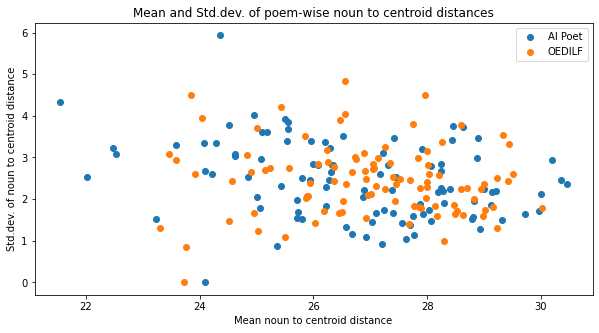

In [184]:
import matplotlib.pyplot as plt
plt.scatter(gpt2_means, gpt2_stds, label='AI Poet')
plt.scatter(oedilf_means, oedilf_stds, label='OEDILF')
plt.title('Mean and Std.dev. of poem-wise noun to centroid distances')
plt.xlabel("Mean noun to centroid distance")
plt.ylabel("Std.dev. of noun to centroid distance")
plt.legend()
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

In [183]:
import scipy

In [170]:
scipy.stats.ttest_ind(oedilf_means, gpt2_means, axis=0, equal_var=False)

Ttest_indResult(statistic=0.8907533175738802, pvalue=0.3741811939324292)